In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

In [7]:
import logging
from pathlib import Path
import textwrap
import copy
from PIL import Image, ImageDraw, ImageFont
from waveshare_epd import epd2in7b

In [8]:
import constants


In [9]:
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

In [278]:
class TextBlock:
    '''Class for creating a 1 bit image of word-wrapped text
    
    Args
    ----
        resolution (int, int): tuple of ints representing maximum resolution of image
        text (str): text to format into image
        font (str): path to ttf font
        size (int): size of font in points (pixles)
        max_lines (int): maximum number of wrapped rows of text; surplus is discarded
        maxchar (int): maximum number of characters per row
            this is automatically calculated if not specified based on font face, font size
            and letter frequency (see chardist below)
        chardist (dict): character frequency distribution for a particular language
            provided distributions in constants.py: 
            USA_CHARDIST+, FRA_CHARDIST, DEU_CHARDIST, PRT_CHARDIST, ITA_CHARDIST, TUR_CHARDIST,
            SWE_CHARDIST, NED_CHARDIST, DAN_CHARDIST
                + only USA english includes upper and lower case characters
        coordinates (int, int): location on screen image should be positioned (not used locally)
    
    Attributes
    ----------
        resolution (int, int): max resolution of image in px
        font (ImageFont.trueType): font and size to use
        maxchar (int): maximum number of characters per row
        max_lines (int): maximum number of wrapped rows of text; surplus is discarded
        coordinates (int, int): position of text in final image (not used in this class)
        size (int, int): size of text image in px
        text (str): raw text
        formatted (str): wrapped text
        textimage (ImageDraw.Draw): 1 bit image containing formatted text text


    '''
    def __init__(self, resolution=(264, 176), text=' ', font=constants.FONT, size=24, max_lines=3,
                 maxchar=None, justify='l', coordinates=(0, 0), chardist=constants.USA_CHARDIST):
        self.resolution=resolution
        self.font = ImageFont.truetype(str(Path(font).absolute()), size)
        self._chardist = chardist
        self.maxchar = maxchar
        self.justify = justify
        self.max_lines = max_lines
        self.coordinates = coordinates
        self.text = text
    
        
    @property
    def resolution(self):
        '''maximum resolution in for image
        
        ::2-tuple of int'''
        return self._resolution
    
    @resolution.setter
    def resolution(self, resolution):
#         for r in resolution:
#             if not isinstance(r, int):
#                 raise TypeError(f'resolution must be type int: {r}')
#             if r < 0:
#                 raise ValueError(f'resolution must be positive: {r}')
        if self.coordcheck(resolution):
            self._resolution = resolution
        else:
            raise ValueError(f'bad resolution value: {resolution}')
    
    @property
    def coordinates(self):
        '''coordinates to place the formatted text within the final image (not used in this method)
        
        ::2 tuple of int'''
        return self._coordinates
    
    @coordinates.setter
    def coordinates(self, coordinates):
        if self.coordcheck(coordinates):
            self._coordinates = coordinates
        else:
            raise ValueError(f'bad coordinate values: {coordinates}')
    
    @property
    def maxchar(self):
        '''maximum number of characters per row
            if no value is set this is calculated based on font face, font size and letter frequency
            
        ::int'''
        return self._maxchar
    
    @maxchar.setter
    def maxchar(self, maxchar):
        if maxchar:
            self.__maxchar = maxchar
            return(maxchar)
        else:
            s = ''
            n = 1000 # sample string size for measuring
            # create a string of characters containing the letter distribution
            for char in self._chardist:
                s = s+(char*int(self._chardist[char]*n))
            sLenPX = self.font.getsize(s)[0] # string length in Pixles
            avgCharLen = sLenPX/len(s)
            maxchar = round(self.resolution[0]/avgCharLen)
            self._maxchar = maxchar
    
    @property
    def text(self):
        '''raw text
        
        ::str'''
        return self._text
    
    @text.setter
    def text(self, text):
        if not text:
            self.text = None
        else:
            self._text = text
            self.formatted = self.formattext()
            self.image = self.textimage()
    
    @property
    def max_lines(self):
        '''maximum number of rows to use when wrapping text
        
        ::int'''
        return self._max_lines
    
    @max_lines.setter
    def max_lines(self, max_lines):
        if max_lines < 1:
            raise ValueError(f'max_lines must be greater than 0: {max_lines}')
        if not isinstance(max_lines, int):
            raise ValueError(f'max_lines must be type integer: {max_lines}')
        self._max_lines = max_lines
    
    def formattext(self, text=None, maxchar=None, max_lines=None, justify=None):
        '''format text using word-wrap strategies
        
        Args
        ----
            text (str): raw text
            maxchar (int): maximum number of characters in each row
            max_lines (int): maximum number of rows
            justify (str): 'l'-left (default), 'c'-center
            
        Returns
        -------
            ::str'''
        
        if not maxchar:
            maxchar = self.maxchar
        if not max_lines:
            max_lines = self.max_lines
        if not text:
            text = self.text
        if not justify:
            justify = self.justify

        wrapper = textwrap.TextWrapper(width=maxchar, max_lines=max_lines)
        lines = wrapper.wrap(text)
        
        # pad out unused lines in max_lines
        if len(lines) < max_lines:
            for i in range(0, max_lines-len(lines)):
                lines.append(" ")

        logging.debug(f'total lines: {len(lines)}')
        if justify == 'c':
            myText = "\n".join(line.center(maxchar) for line in lines)
        else:
            myText = "\n".join(line for line in lines)
    
        # always return a string with at least one character
        if len(myText) < 1:
            myText = ' '
        
        return(myText)
    
    def textimage(self, text=None, coordinates=None):
        '''produces 1 bit image of containing wrapped text
        
        Args
        ----
            text (str): raw text to use; if non is provided use self.text
            coordinates (int): coordinates of text in final image (not used in this class)
            
        Returns
        -------
            ::Image.new()'''
        if text:
            text = self.formattext(text)
        else:
            text = self.formatted
            
        if not coordinates:
            coordinates = self.coordinates

        # get the size of the text
        draw = ImageDraw.Draw(Image.new('1', (1, 1))) # create a dummy image and drawing instance
        self.size = draw.textsize(text, self.font)
        
        logging.debug(f'text size: {self.size}')
        # create an empty image
        image = Image.new('1', self.size, 255) # create a blank image 
        # get a drawing context
        draw = ImageDraw.Draw(image)
#         draw.text        
        draw.text((0,0), text, font=self.font) # draw the text at the origin
        self.image = image
        return image

    def coordcheck(self, coordinates):
        for c in coordinates:
            if not isinstance(c, int):
                raise TypeError(f'coordinate must be type int: {c}')
                return False # redundant
            if c < 0:
                raise ValueError(f'coordinate must be positive: {c}')
                return False # redundant
        return True

In [327]:
class Screen:
    def __init__(self, resolution=(264, 176), elements=[], epd=None):
        self.resolution = resolution
        self.elements = elements
        self.image = self.clearScreen()
        self.epd = epd
        
    @property
    def resolution(self):
        return self._resolution
    
    @resolution.setter
    def resolution(self, resolution):
        if self.coordcheck(resolution):
            self._resolution = resolution
    
    def clearScreen(self):
        '''sets base image for building screen to an empty background'''
        self.image = Image.new('1', self.resolution, 255)
        return self.image

    def concat(self, elements=None):
        if elements:
            elements = elements
        else:
            elements = self.elements
    
        for e in self.elements:
            self.image.paste(e.image, (e.coordinates))
        return(self.image)
        
    def coordcheck(self, coordinates):
        for c in coordinates:
            if not isinstance(c, int):
                raise TypeError(f'coordinate must be type int: {c}')
                return False # redundant
            if c < 0:
                raise ValueError(f'coordinate must be positive: {c}')
                return False # redundant
        return True        
    
    def initEPD(self):
        if not self.epd:
            raise UnboundLocalError('no epd object has been assigned')
        try:
            self.epd.init()
        except Exception as e:
            logging.error(f'failed to init epd: {e}')
    
    def clearEPD(self):
        if not self.epd:
            raise UnboundLocalError('no epd object has been assigned')
        try:
            self.epd.Clear();
        except Exception as e:
            logging.error(f'failed to clear epd: {e}')
    
    def writeEPD(self, image=None):
        epd = self.epd
        if not self.epd:
            raise UnboundLocalError('no epd object has been assigned')
        try:
            epd.display(epd.getbuffer(self.image), epd.getbuffer(Image.new('1', (epd.height, epd.width), 255)))
            epd.sleep()
        except Exception as e:
            logging.error(f'failed to write to epd: {e}')
        
        

In [330]:
t = TextBlock(text="Lovely Creature", size=36, coordinates=(5, 0), justify='c')
t.formatted

DEBUG:root:total lines: 3
DEBUG:root:text size: (193, 125)


'    Lovely   \n   Creature  \n             '

In [331]:
a = TextBlock(text='Nick Cave and The Bad Seeds', size = 18, coordinates=(5, t.size[1]), max_lines=2)

DEBUG:root:total lines: 2
DEBUG:root:text size: (193, 44)


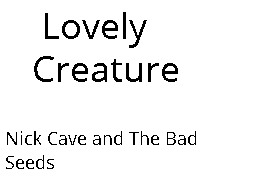

In [332]:
s = Screen(elements=[a, t])
s.concat()

In [333]:
s.epd = epd2in7b.EPD()
s.initEPD()
# s.clearEPD()
s.writeEPD()

DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:Horizontal
DEBUG:root:Horizontal
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:spi end
DEBUG:root:close 5V, Module enters 0 power consumption ...


In [324]:
e = epd2in7b.EPD()


In [326]:
e.init()

DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release


0

In [ ]:
e.sleep()

In [78]:
e.Clear()

DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release


In [110]:
b = Image.new('1', (e.height, e.width), 255)
r = Image.new('1', (e.height, e.width), 255)
f = ImageFont.truetype(font=constants.FONT, size=24)
bDraw = ImageDraw.Draw(b)

In [111]:
bDraw.text((0, 0), "hello world", font=f)

In [122]:
e.display(e.getbuffer(s.image), e.getbuffer(Image.new('1', (e.height, e.width), 255)))

DEBUG:root:Horizontal
DEBUG:root:Horizontal
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release


In [80]:
# ((size), (position))
# find the size if all images were concatinated together
cords = [((10, 10), (50, 10)), ((120, 120), (0, 0)), ((120, 120), (120, 0)), ((240, 60), (0, 120)), ((50, 100), (170, 70))]

In [81]:
x = 0
y = 0
lastX = 0
lastY = 0
for c in cords:
    thisX = c[1][0] + c[0][0]
    thisY = c[1][1] + c[0][1]
    
    if thisX > lastX:
        lastX = thisX
        print(f'found a new X max {lastX}')
    
    if thisY > lastY:
        lastY = thisY
        print(f'found a new Y max {lastY}')
        
print(lastX, lastY)

found a new X max 60
found a new Y max 20
found a new X max 120
found a new Y max 120
found a new X max 240
found a new Y max 180
240 180


In [100]:
st = 'foo\n'

In [157]:
text = "If true, then words longer than width will be broken in order to ensure that no lines are longer than width. If it is false, long words will not be broken, and some lines may be longer than width. (Long words will be put on a line by themselves, in order to minimize the amount by which width is exceeded.)"
w = textwrap.wrap(text)


AttributeError: 'list' object has no attribute 'fill'

In [158]:
tw = textwrap.TextWrapper(width=40, max_lines=3)

In [161]:
lines = tw.wrap(text)
"\n".join(line for line in lines)


'If true, then words longer than width\nwill be broken in order to ensure that\nno lines are longer than width. If [...]'

In [146]:
tw = textwrap.TextWrapper(width=20, max_lines=3)
lines = tw.wrap(text)
t = "\n".join(line.center(20) for line in lines)
print(t)

If true, then words 
 longer than width  
will be broken [...]
